# Stock Price Prediction Using Random Forest

In this notebook, we will be exploring the performance of the random forest classifier on the S&P500 stock data.

## Notas

Preciso de 15 dias de dados antes de 2010 para calcular umas coisas, ou então removo aproximadamente 13 ou 14 colunas.

Sources:
 - [Exponential Smoothing](https://medium.com/@criesin.90days/stock-price-forecasting-with-exponential-smoothing-an-analytical-project-report-380c7ca694a8)
 - [The Random Forest Model for Analyzing and Forecasting the US Stock Market in the Context of Smart Finance](https://arxiv.org/pdf/2402.17194)

In [163]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import random
import math
import matplotlib.pyplot as plt

# Data Preprocessing

In [164]:
df_apple = pd.read_csv('./clean_csvs/AAPL.csv')

df_apple.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


## Obtaining Recommended Features

<center>

![](./images/features_paper1.png)

</center>

 - **RSI (Relative Strength Index)**: The RSI measures the speed and change of price movements. It oscillates between 0 and 100 and is calculated over a specific period (e.g., 14 days).

<center>

$
RSI = 100 - \frac{100}{1 + RS}
$      

</center>

<center>

where

</center>

<center>

$
RS = \frac{\text{Average Gain over N periods}}{\text{Average Loss over N periods}}
$

</center>

In [165]:
def addRSI(df):    

    window_length = 14  # Standard Value
    
    # Calculate price differences
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
    avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

    # Calculate RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))


 - **Stochastic Oscillator**:
Measures the closing price relative to the price range over a period of time (e.g., 14 days).

<center>

$
\%K = \frac{\text{Close} - \text{Low}_N}{\text{High}_N - \text{Low}_N} \times 100
$

</center>


In [166]:
def addK(df):
    n = 14  # Look-back period
    df['%K'] = ((df['Close'] - df['Low'].rolling(n).min()) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min())) * 100

 - **Williams %R**:
Similar to the stochastic oscillator but inverted and shifted.

<center>

$
\%R = \frac{\text{High}_N - \text{Close}}{\text{High}_N - \text{Low}_N} \times -100
$

</center>


In [167]:
def addR(df):
    n = 14
    highn_close = (df['High'].rolling(n).max() - df['Close'])
    highn_lown = (df['High'].rolling(n).max() - df['Low'].rolling(n).min())
    df['%R'] = (highn_close / highn_lown) * (-100)

 - **MACD (Moving Average Convergence Divergence)**:
Measures the difference between a fast and a slow exponential moving average (EMA).

In [168]:
def addMACD(df):
    fast_period = 12
    slow_period = 26
    signal_period = 9

    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA_fast'] - df['EMA_slow']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

 -  **Price Rate of Change (ROC)**:
Measures the percentage change in price over a given time.

<center>

$
ROC = \frac{\text{Close}_t - \text{Close}_{t-n}}{\text{Close}_{t-n}} \times 100
$

</center>


In [169]:
def addROC(df):
    n = 14  # Period
    df['ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

 - **On-Balance Volume (OBV)**:
Measures buying and selling pressure using volume.

In [170]:
def addOBV(df):
    df['Direction'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['OBV'] = (df['Direction'] * df['Volume']).cumsum()

### Adding Paper Recommended Features

In order to facilitate adding features to any dataframe, we decided to build this function, which already **removes NaN values automatically**. We have 2 different options to do so:
 - Removing the first 14 rows of the dataframe, as they are entered due to the **look-back period**, which is never higher than 14.
 - Removing only 2 rows, but deleting the `%K`, `%R` and `ROC` columns entirely.

We decided to implement this possibility, in case dimentionality is a problem in the future.

In [171]:
def addFeatures(df, rows=True):
    addRSI(df)
    addK(df)
    addR(df)
    addMACD(df)
    addROC(df)
    addOBV(df)

    # Removes first 14 rows of the dataset 
    if rows: df.drop(index=range(0, 14), inplace=True)

    # Removes first 2 rows of the dataset, and the `%K`, `%R` and `ROC` columns
    else: 
        df.drop(index=range(0, 2), inplace=True)
        df.drop(columns=['ROC','%K', '%R'], inplace=True)

In [172]:
addFeatures(df_apple, False)

df_apple.head(15)

,Date,AdjClose,Close,High,Low,Open,Volume,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000,9.788567,7.628231,7.636078,-0.007847,-0.001401,-1,49744800
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200,8.873044,7.611690,7.627533,-0.015843,-0.004289,-1,-427386400
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800,31.777433,7.605386,7.623324,-0.017938,-0.007019,1,20224400
5,2010-01-11,6.329920,7.503929,7.607143,7.444643,7.600000,462229600,23.790476,7.589777,7.614480,-0.024703,-0.010556,-1,-442005200
6,2010-01-12,6.257915,7.418571,7.491786,7.372143,7.471071,594459600,18.006175,7.563438,7.599968,-0.036530,-0.015751,-1,-1036464800
7,2010-01-13,6.346186,7.523214,7.533214,7.289286,7.423929,605892000,36.833856,7.557250,7.594283,-0.037033,-0.020007,1,-430572800
8,2010-01-14,6.309431,7.479643,7.516429,7.465000,7.503929,432894000,33.619494,7.545310,7.585791,-0.040481,-0.024102,-1,-863466800
9,2010-01-15,6.203987,7.354643,7.557143,7.352500,7.533214,594067600,26.887912,7.515977,7.568669,-0.052692,-0.029820,-1,-1457534400
10,2010-01-19,6.478441,7.680000,7.685357,7.401429,7.440357,730007600,51.936811,7.541211,7.576915,-0.035704,-0.030997,1,-727526800
11,2010-01-20,6.378724,7.561786,7.698214,7.482143,7.675357,612152800,46.187316,7.544376,7.575795,-0.031418,-0.031081,-1,-1339679600


---

## Introduction to Model Development

In [173]:
# Convert Date to datetime and sort by Date
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple = df_apple.sort_values(by='Date')

# Removing adjusted close from training data
df_apple = df_apple.drop(columns=['AdjClose'])

Because we cannot pass `datetime` objects into the random forest, we need to create new columns to represent day, month and year, thus preserving sequential importance.

In [174]:
# Extract temporal features
df_apple['Day'] = df_apple['Date'].dt.day
df_apple['Month'] = df_apple['Date'].dt.month
df_apple['Year'] = df_apple['Date'].dt.year

In [175]:
df_apple.head()

,Date,Close,High,Low,Open,Volume,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV,Day,Month,Year
2,2010-01-06,7.534643,7.686786,7.526786,7.656429,552160000,9.788567,7.628231,7.636078,-0.007847,-0.001401,-1,49744800,6,1,2010
3,2010-01-07,7.520714,7.571429,7.466071,7.562500,477131200,8.873044,7.611690,7.627533,-0.015843,-0.004289,-1,-427386400,7,1,2010
4,2010-01-08,7.570714,7.571429,7.466429,7.510714,447610800,31.777433,7.605386,7.623324,-0.017938,-0.007019,1,20224400,8,1,2010
5,2010-01-11,7.503929,7.607143,7.444643,7.600000,462229600,23.790476,7.589777,7.614480,-0.024703,-0.010556,-1,-442005200,11,1,2010
6,2010-01-12,7.418571,7.491786,7.372143,7.471071,594459600,18.006175,7.563438,7.599968,-0.036530,-0.015751,-1,-1036464800,12,1,2010


In [176]:
# Train with 2010 - 2023
train_data = df_apple[(df_apple['Date'] >= '2010-01-01') & (df_apple['Date'] < '2024-01-01')]

# Test with January 2024
test_data = df_apple[(df_apple['Date'] >= '2024-01-01') & (df_apple['Date'] < '2024-02-01')]

# Separates train_data into X and y
X_train = train_data.drop(columns=['Volume','Date','Close', 'High', 'Low', 'Open'])
y_train = train_data['Close']

In [177]:
X_train.head()

,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV,Day,Month,Year
2,9.788567,7.628231,7.636078,-0.007847,-0.001401,-1,49744800,6,1,2010
3,8.873044,7.611690,7.627533,-0.015843,-0.004289,-1,-427386400,7,1,2010
4,31.777433,7.605386,7.623324,-0.017938,-0.007019,1,20224400,8,1,2010
5,23.790476,7.589777,7.614480,-0.024703,-0.010556,-1,-442005200,11,1,2010
6,18.006175,7.563438,7.599968,-0.036530,-0.015751,-1,-1036464800,12,1,2010


In [178]:
y_train.head()

2    7.534643
3    7.520714
4    7.570714
5    7.503929
6    7.418571
Name: Close, dtype: float64

In [179]:
# Separates test_data into X and y
X_test = test_data.drop(columns=['Volume','Date','Close', 'High', 'Low', 'Open'])
y_test = test_data['Close']

# Keep for reference during performance analysis
y_test_dates = test_data['Date']  

In [180]:
X_test.head()

,RSI,EMA_fast,EMA_slow,MACD,Signal_Line,Direction,OBV,Day,Month,Year
3522,31.663452,192.642575,191.860181,0.782394,2.096536,-1,16138533900,2,1,2024
3523,24.387836,191.351410,191.296464,0.054946,1.688218,-1,16080119400,3,1,2024
3524,8.867228,189.898886,190.601171,-0.702285,1.210118,-1,16008135800,4,1,2024
3525,7.864614,188.557518,189.903306,-1.345788,0.698936,-1,15945832500,5,1,2024
3526,24.905980,188.096361,189.581579,-1.485219,0.262105,1,16004977000,8,1,2024


In [181]:
y_test_dates.head()

3522   2024-01-02
3523   2024-01-03
3524   2024-01-04
3525   2024-01-05
3526   2024-01-08
Name: Date, dtype: datetime64[ns]

In [182]:
y_test.head()

3522    185.639999
3523    184.250000
3524    181.910004
3525    181.179993
3526    185.559998
Name: Close, dtype: float64

---

## Random Forest: Model Inherent Problem

Random Forests require the same input as they were trained on. The model is trained on infromation derived from closing prices, so that means that if we wish to predict closing prices for January 2024, we would already need to know the closing prices for January 2024. This violates the concept of prediction, which is to predict future values based on past values. 

We must get creative in order to find a solution!

We already know RF's are not built to handle sequential data. In order to show relevance regarding time series, we have already **implemented 3 columns to represent dates**.

However, the most prominent issue is that we currently need future data to predict said future data.

In order to mitigate this problem, we decided to split the training and prediction process into very specific steps:

 - Get financial metrics for 13 years
 
 - Use information available online to create functions that emulate patterns followed by each metric, based on statistics
 
 - Use those functions to determine values those metrics are likely to show in January, based on 13 years of data

 - Create a new test dataframe containing approximate values
 
 - Fit to a final, independent model to predict the stock price for January 2024

In order to do this, we have also applied **MinMax scaling to the dataframe**.

In [183]:
df_apple = pd.read_csv('./clean_csvs/TSLA.csv')

In [184]:
def apply_minmax_scaling(train_df, test_df, columns_to_scale):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the training data and transform it
    train_scaled = train_df.copy()  
    train_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])

    # Transform the test data using the same scaler (tests inside the same interval)
    test_scaled = test_df.copy()  
    test_scaled[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

    return train_scaled, test_scaled

In order to aid the classification task, due to the presence of floating point values, we decided to implement a form of **binning**, based on the **Sturges' Rule**:
<br>
<center>

$
\text{Number of bins} = \lceil \log_2(N) + 1 \rceil
$

</center>

## Predicting Metrics

In [185]:
def predictMetric(train_dataframe, test_dataframe, target):

    # Fill missing values (NaNs) with the median of the respective column (prevents errors)
    train_dataframe[['Day', 'Month', 'Year', target]] = train_dataframe[['Day', 'Month', 'Year', target]].fillna(train_dataframe[['Day', 'Month', 'Year', target]].median())
    test_dataframe[['Day', 'Month', 'Year']] = test_dataframe[['Day', 'Month', 'Year']].fillna(test_dataframe[['Day', 'Month', 'Year']].median())

    # Uses date to predict
    X_train = train_dataframe[['Day','Month','Year']] 
    y_train = train_dataframe[target]  
    
    X_test = test_dataframe[['Day','Month','Year']]
    
    rf = RandomForestRegressor(n_estimators=125, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predictst for January 2024
    test_dataframe[target] = rf.predict(X_test)

## Splitting Predicted Data

In [186]:
def split_data(df, target='Close', colsRemove=['Date','Close', 'High', 'Low', 'Open','AdjClose','Volume'], 
               scale=False, intervals=False, showIntervals=False):
    
    # Convert Date to datetime and sort by Date
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Extract temporal features
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    # 2010 - 2023
    train_data = df[(df['Date'] >= '2010-01-01') & (df['Date'] < '2024-01-01')]

    # Test with January 2024
    test_data = df[(df['Date'] >= '2024-01-01') & (df['Date'] < '2024-02-01')]

    metrics_to_predict = ['RSI','EMA_fast','EMA_slow','MACD','Signal_Line','Direction','OBV']

    #print(train_data.head())
    #print(test_data.head())

    for metric in metrics_to_predict:
        predictMetric(train_data, test_data, metric)

    minmax_cols = ['RSI','EMA_fast','EMA_slow','MACD','Signal_Line','Direction','OBV','Close']

    if scale: train_data, test_data = apply_minmax_scaling(train_data, test_data, minmax_cols)

    # Closing price must not be placed into intervals to preserve behaviour
    if intervals: train_data, test_data = apply_interval_division(train_data, test_data, metrics_to_predict,showIntervals)

    #print(train_data.head())
    #print(test_data.head())

    # Separates train_data into X and y
    X_train = train_data.drop(columns=colsRemove, errors='ignore')
    y_train = train_data[target]

    # Separates test_data into X and y
    X_test = test_data.drop(columns=colsRemove, errors='ignore')
    y_test = test_data[target]

    # Keep for reference during performance analysis
    y_test_dates = test_data['Date']  

    return X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data

In [187]:
# Combine all functions
def preprocess_and_split(df, target='Close', colsRemove=['Date','Close', 'High', 'Low', 'Open','AdjClose','Volume'], 
                         rows=False, scale=False, intervals=False, showIntervals=False):
    
    df_preprocess = df.copy()

    addFeatures(df_preprocess, rows)
    
    X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = split_data(df_preprocess, target, colsRemove, scale, intervals, showIntervals)

    return X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data

In [188]:
# Applies a type of binning to the train and test dataframes 
def apply_interval_division(train_df, test_df, columns_to_divide, separate=False, slices=10, showIntervals=False):
    tr_df = train_df.copy()
    te_df = test_df.copy()
    if separate:
        for c in columns_to_divide:
            min_train, max_train = train_df[c].min(), train_df[c].max()
            min_test, max_test = test_df[c].min(), test_df[c].max()
    else:

        for c in columns_to_divide:
            df_min = min(train_df[c].min(), test_df[c].min())
            df_max = max(train_df[c].max(), test_df[c].max())

            # Creates intervals based on the Sturges' Rule
            max_intervals = max(math.ceil(math.log(len(c),2)), slices)
            bin_edges = np.linspace(df_min, df_max, max_intervals)

            if showIntervals:
                intervals = [
                f"[{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f})" if (i < len(bin_edges) - 2) 
                else f"[{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]"
                for i in range(len(bin_edges) - 1)]
                print(intervals, len(intervals))

            # Digitize the train and test data into bins
            # If we use labels=False -> automatically transforms the intervals into integers
            tr_df[c] = pd.cut(train_df[c], bins=bin_edges, labels=False, include_lowest=True)
            te_df[c] = pd.cut(test_df[c], bins=bin_edges, labels=False, include_lowest=True)

    return tr_df, te_df


In [189]:
warnings.filterwarnings('ignore')

X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df_apple,scale=True,intervals=True)

Because the values are all standardized to MinMax scaling, we can split them into easily comprehensible intervals. The number of intervals is modifiable.

The code above also automatically transforms each interval into an integer.

In [190]:
train_data["EMA_fast"].values

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

---

In [191]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=45)
model.fit(X_train, y_train)

# Predict for January 2024
predictions = model.predict(X_test)

# Create dataframe with results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

In [192]:
results.head()

,Date,Predicted_Close
3400,2024-01-02,0.277863
3401,2024-01-03,0.277863
3402,2024-01-04,0.287996
3403,2024-01-05,0.268894
3404,2024-01-08,0.289850


In [193]:
if 'Close' in test_data.columns:
    y_test = test_data['Close']
    rmse = root_mean_squared_error(y_test, predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.2189435240362882


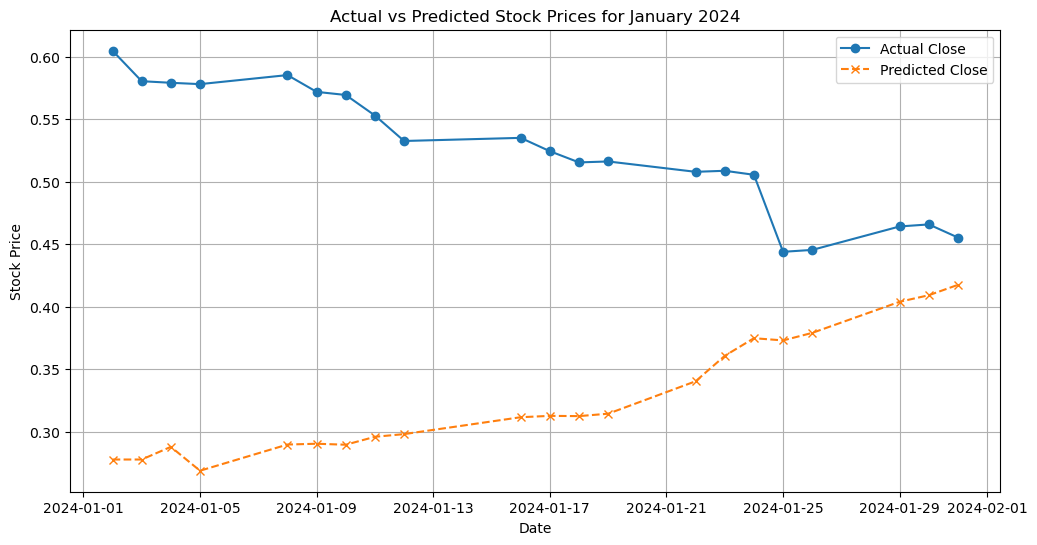

In [194]:
plt.figure(figsize=(12, 6))

# Plot real prices
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close', marker='o')

# Plot predicted prices
plt.plot(y_test_dates, predictions, label='Predicted Close', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for January 2024')
plt.legend()
plt.grid(True)
plt.show()


As we have demonstrated in the report, all stock prices generaly follow the GSPC. This means that most of their patterns are quite similar to each other, meaning that the best RF settings for a small sample of different stocks should be the best settings overall.

In [195]:
def optimize_rf_hyperparameters(data_folder, num_samples=50):

    results = []
    
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Randomly choose 50 files (10% of total files)
    csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    sampled_files = random.sample(csv_files, min(num_samples, len(csv_files)))

    for file_name in tqdm(sampled_files, desc="Processing CSV files"):
        df = pd.read_csv(os.path.join(data_folder, file_name))
        
        X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df, scale=True, intervals=False)
    
        rf = RandomForestRegressor()
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=20,  # Number of random combinations to test
            cv=3,       
            n_jobs=-1,  # Use all available cores
            verbose=0,  
        )

        try:
            random_search.fit(X_train, y_train)
        except Exception as e:
            print(f"Error in processing CSV file: {file_name}")
            print(f"Error details: {str(e)}")

        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
        predictions = best_model.predict(X_test)
        rmse = root_mean_squared_error(y_test, predictions)

        # Each parameter represents a column
        result = {'file_name': file_name, 'rmse': rmse}
        for param, value in best_params.items():
            result[param] = value

        # Save best results
        results.append(result)

    results_df = pd.DataFrame(results)
    results_df.to_csv('./pickle_jar/rf_tuning_results.csv', index=False)
    print("Randomized Search complete!")

    return results_df

Simply change this cell to python in order to run the code.

```py
results_df = optimize_rf_hyperparameters('./clean_csvs', 50)
```

In [196]:
def convertNp(val):
    if isinstance(val, np.int64): return int(val)
    elif isinstance(val, np.bool_): return bool(val)
    elif isinstance(val, np.float64): return float(val)
    return val

In [197]:
results_df = pd.read_csv('./pickle_jar/rf_tuning_results.csv')

results_df = results_df.where(pd.notnull(results_df), None)

# Identify the most common value for each column (should be the overall best)
most_common_params = {}
for column in results_df.columns[2:]: 
    most_common_value = results_df[column].mode()
    
    if not most_common_value.empty:
        most_common_params[column] = convertNp(most_common_value[0])
    else:
        most_common_params[column] = None  


# Create the final dictionary with the best parameters
print("Best Hyperparameters: \n")
print(most_common_params)

results_df.head()

Best Hyperparameters: 

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20.0, 'bootstrap': True}


,file_name,rmse,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
0,NOC.csv,0.050204,50,2,1,log2,30.0,False
1,PH.csv,0.379378,150,2,2,log2,10.0,True
2,RVTY.csv,0.148504,50,10,1,sqrt,30.0,False
3,F.csv,0.055861,50,2,4,sqrt,NaN,True
4,GL.csv,0.024587,200,2,2,sqrt,30.0,True


### Generalization

Now that we have the best parameters regarding our datasets, we can obtain predictions and buy signals 

In [198]:
X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df_apple)

In [199]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, 
                              max_features='sqrt', max_depth=20, bootstrap=True)
model.fit(X_train, y_train)

# Predict for January 2024
predictions = model.predict(X_test)

# Create dataframe with results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

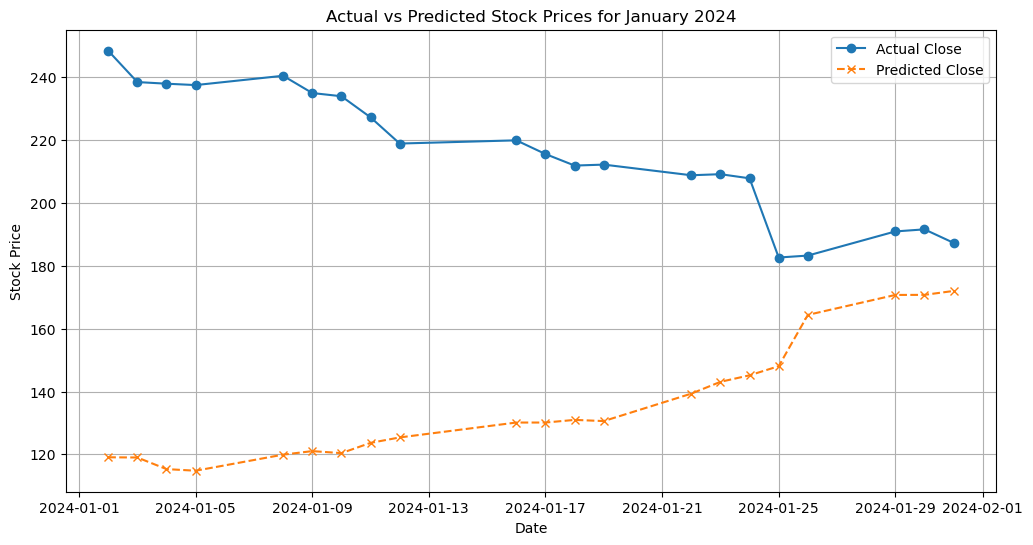

In [200]:
plt.figure(figsize=(12, 6))

# Plot real prices
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close', marker='o')

# Plot predicted prices
plt.plot(y_test_dates, predictions, label='Predicted Close', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for January 2024')
plt.legend()
plt.grid(True)
plt.show()
